## はじめに
### 書こうと思ったきっかけ
実習中論文を頂いて読む機会が多いが、医学論文は薬は新しい治療方法の成績を比較しているのが多い。
だいたい **Kaplan-Meier曲線** が使われているので(偏見)、論文を読むときにはもちろん、将来自分が論文を執筆するときに、何が行われているのか少しでも理解できていればいいかなと思いまとめてみた。

### Kaplan-Meier 曲線とは
[Wikipedia](https://ja.wikipedia.org/wiki/%E7%94%9F%E5%AD%98%E7%8E%87%E6%9B%B2%E7%B7%9A)によると「治療を行った後の患者の生存率をグラフにしたもの」ということらしい。ただ、実際には問題がいくつかあって

- 観察期間は限られている(患者さんを何年もフォローすることはできない)
- 観察不能になることがある(病院移った、他の要因で死亡したなど)
- 患者さんによって観察開始時間は様々(みんな一緒に罹患したり治療を開始するわけではない)
そういった問題をうまく対処してくれるのがKaplan-Meier曲線。

Kaplan-Meier曲線の縦軸は累積生存率で、

$$
S(t)=\prod_j^t  \left(1-\frac{d_j}{n_j}\right)
$$

で表されます。ここで$d_j$は時間$j$における死亡者数で、$n_j$は時間$j$における生存者数です。

今回はpythonのコードでKaplan-Meier曲線を書いていこうと思います。
pythonのライブラリにlifelinesという便利なライブラリがあるのでそれを使っていこうと思います。installはpipでできます：`pip install lifelines`

## データの準備
ある病気に対する治療法の予後のKaplan-Meier曲線を描きたいとします。
ある期間内に観察された患者の経過をみることになると思いますが、患者さんによって発症する時間も様々なので、イメージとして下の図のようになると思います。

Observed lifetimes at time 48:
 [37 40 48 32 30 48 48 48 20 43 37 18 45 44 46 42 30 48  6 23 43 16 48 32
 48 48 16 42 21 47 48 17 47 48 11 48 13  8 48 29 27 33 48 32  6 48 48 35
 39 45]


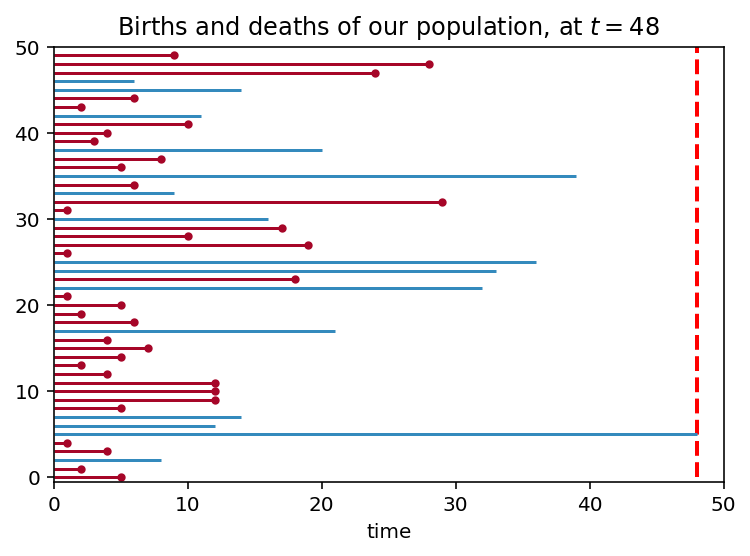

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

N = 50
current_time = 48
birth = np.random.randint(0,45,50)
actual_lifetimes = np.array([[int(exponential(20))+1, int(exponential(10))+1][uniform() < 0.5] for i in range(N)])
observed_lifetimes = np.minimum((actual_lifetimes+birth), current_time)
observed = (birth + actual_lifetimes) < current_time

plt.xlim(0, 50)
plt.vlines(48, 0, 50, lw=2, linestyles='--',colors='red')
plt.xlabel("time")
plt.title("Births and deaths of our population, at $t=48$")
plot_lifetimes(observed_lifetimes-birth, 
               event_observed=observed, 
               birthtimes=birth,
               sort_by_duration=False)
#plot_lifetimes(observed_lifetimes-birth, event_observed=observed,birthtimes=birth)
print("Observed lifetimes at time %d:\n" % (current_time), observed_lifetimes)

赤線では期間内(t=48)に患者さんが死亡したケース、青線は観測不能になったケースです(観察期間終わったからそれ以上追えない)。

簡単のため、観測不能になったケースは観測期間が終わった場合のみとします。観察期間の長さでソートすると、下の図のようになります（defaultはソートされて出力されます）。

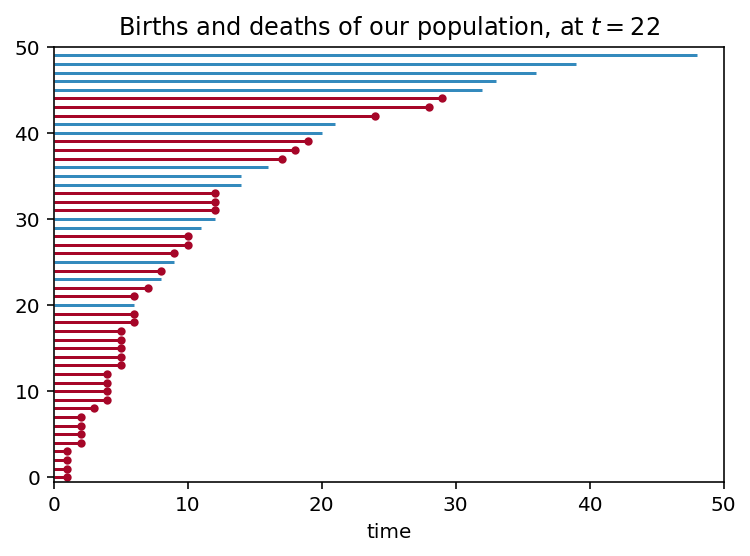

In [2]:
s = pd.Series(observed_lifetimes-birth,observed)
s = s.sort_values()
s.name = 'time'
observed, result_lifetimes = s.index, s.values

plt.xlim(0,50)
#plt.vlines(22, 0, 30, lw=2, linestyles='--',colors='red')
plt.xlabel("time")
plt.title("Births and deaths of our population, at $t=22$")
plot_lifetimes(result_lifetimes, event_observed=observed)

## 実際の計算
さっき作ったデータを使って、累積生存率を計算していきます。たとえばt=5における累積生存率を計算するとき、

In [3]:
pd.DataFrame(s).head(12)

,time
True,1
True,1
True,1
True,1
True,2
True,2
True,2
True,2
True,3
True,4


rueが患者さんが死亡したのを観測できた事例、Falseが観察期間終了により観測できなかった事例です。観察期間の短い順に見ていくと、

- t=1のとき、50人のうち2人が死亡,1人が打ち切り。
- t=2のとき、死亡者、打ち切りなし。
- t=3の時は４７人のうち１人が死亡。
- t=4の時は46人のうち２人が死亡、２人が打ち切り。
- t=5の時は42人中１人死亡、３人が打ち切り。

よって$ S(5)$は

$$
S(5)=\left(1-\frac{1}{50}\right)\left(1-\frac{0}{47}\right)\left(1-\frac{1}{47}\right)\left(1-\frac{2}{46}\right) \left(1-\frac{1}{42}\right) \simeq 0.896
$$

となります。

## 結果のプロット
ここら辺の計算と描画はライブラリに任せます。

やってることは各期間の点における累積生存率をプロットして線を横に伸ばすだけです。

C:\Users\user\miniconda3\lib\site-packages\lifelines\utils\__init__.py:1172: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


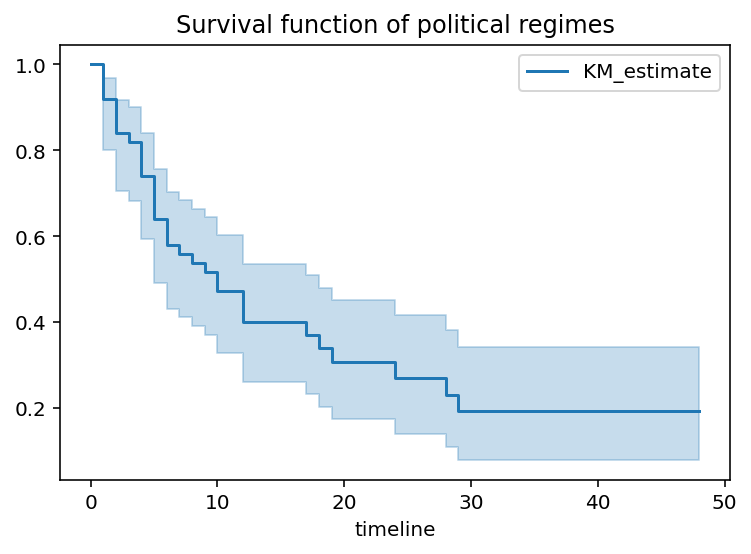

In [4]:
kmf = KaplanMeierFitter()
kmf.fit(result_lifetimes,event_observed=observed)
kmf.plot()
plt.title('Survival function of political regimes');

## 乳がんデータセットを用いて解析を行った例
一応これで生存曲線は描けた訳ですが、もし治療の有効性を示すのであれば、他の治療群と比較して、有効性を示さなければいけません。

ここから使われる統計手法はLog-rank検定、一般化wilcoxon検定など様々ですが、ここではcox比例ハザードを使った回帰分析を例にして解析を進めていきます。なお、cox比例ハザードモデルに関する説明は[このpdf](http://www012.upp.so-net.ne.jp/doi/biostat/CT39/Cox.pdf)がわかりやすかったです。

lifelinesライブラリに乳がんの予後のデータセットがあるのでそれを用います。調べたいことは、乳がんの治療でどのような因子が予後に影響を及ぼすのかということです。

### hormone therapyの有無で2群に分けKaplan-Meier曲線を描いた例

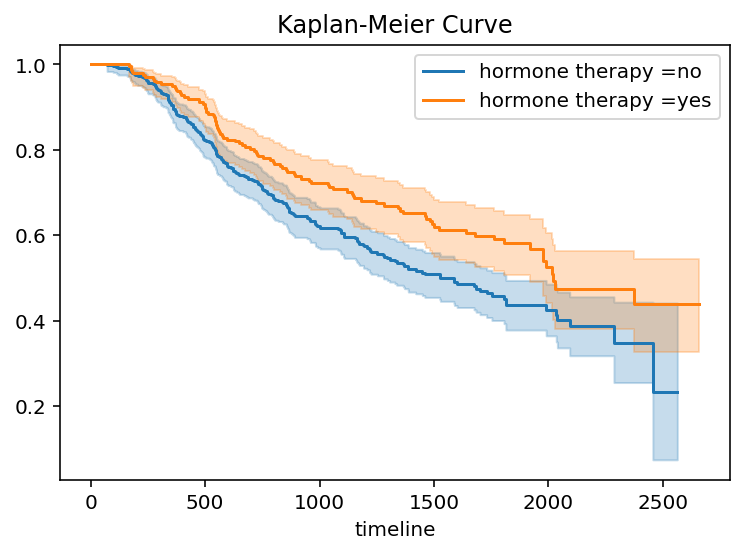

In [5]:
from lifelines.datasets import load_gbsg2
df = load_gbsg2()
ax = None
for name, group in df.groupby('horTh'):
    kmf = KaplanMeierFitter()
    kmf.fit(group['time'], event_observed=group['cens'],
            label = 'hormone therapy =' + str(name))
    # 描画する Axes を指定。None を渡すとエラーになるので場合分け
    if ax is None:
        ax = kmf.plot()
    else:
        ax = kmf.plot(ax=ax)
plt.title('Kaplan-Meier Curve')
plt.show()

### Cox比例ハザードモデル(CoxPH model)の適応

In [6]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
df = pd.get_dummies(df,columns=['horTh','menostat'],drop_first=True)
df.drop('tgrade',axis = 1,inplace = True)
cph.fit(df, duration_col='time', event_col='cens', show_progress=True)

Iteration 1: norm_delta = 0.67037, step_size = 0.9500, log_lik = -1788.10474, newton_decrement = 55.61167, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.30017, step_size = 0.9500, log_lik = -1781.26562, newton_decrement = 31.96515, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.10001, step_size = 0.9500, log_lik = -1745.22376, newton_decrement = 3.94652, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.02132, step_size = 1.0000, log_lik = -1740.82728, newton_decrement = 0.16247, seconds_since_start = 0.1
Iteration 5: norm_delta = 0.00107, step_size = 1.0000, log_lik = -1740.65978, newton_decrement = 0.00038, seconds_since_start = 0.1
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, log_lik = -1740.65940, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>

CoxPH回帰の結果のsummary

In [7]:
cph.print_summary()

CoxPH回帰の結果のplot

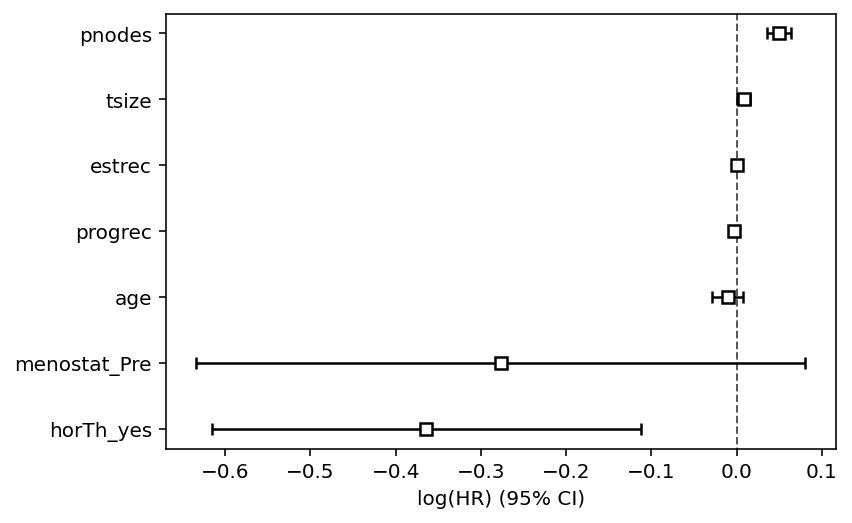

In [8]:
cph.plot()

## まとめ
- Kaplan-Meier曲線がどのように作られているか分かった。
- pythonを用いて割と簡単に統計解析ができた。
- 統計モデルについても定義からもう少し詳しく説明できたらよかったが、latex使うのめんどくさくて諦めた。リンク参考にしてください。

## 参考HP
- <a href="https://lifelines.readthedocs.io/en/latest/index.html">lifelines公式HP</a>
- <a href="https://istat.co.jp/sk_commentary/kaplan_meier">相関、検定の手法別解説</a>
- <a href="http://www.emalliance.org/%E6%9C%AA%E5%88%86%E9%A1%9E/%E7%AC%AC%EF%BC%97%E5%9B%9Eema-jc%E3%80%80%E8%A7%A3%E8%AA%AC%E3%80%80%E3%82%AB%E3%83%97%E3%83%A9%E3%83%B3%E3%83%9E%E3%82%A4%E3%83%A4%E3%83%BC%E7%94%9F%E5%AD%98%E6%9B%B2%E7%B7%9A">EM Aliance</a>